In [3]:
import torch
import os

from src import *

import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import numpy as np

external_path=''

In [15]:
def get_cbv_vectors(positive_digit,negative_digit,num_steps=10000,lr=1e-3):
    #if not(os.path.exists(f'{external_path}\\concept_boundary_vectors\\log.txt')):
    #    log_file=open(f'{external_path}\\concept_boundary_vectors\\log.txt','w')
    #else:
    #    log_file=open(f'{external_path}\\concept_boundary_vectors\\log.txt','a')

    normals=np.load(f'{external_path}\\boundary_info\\normals\\{positive_digit}_{negative_digit}.npy')
    normals=torch.tensor(normals).float()

    optimized_vector=torch.rand((normals.shape[1]))
    optimized_vector=(optimized_vector/torch.norm(optimized_vector)).requires_grad_()

    norm_opt=torch.optim.SGD([optimized_vector],lr=lr)

    steps=0
    while steps<num_steps:
        epoch_loss=0
        for k in range(normals.shape[0]):
            norm_opt.zero_grad()
            dot=torch.dot(optimized_vector,normals[k,:])/torch.norm(optimized_vector)
            loss=torch.abs(1-dot)
            loss.backward()
            norm_opt.step()
            epoch_loss+=loss
            steps+=1

    #np.save(f'{external_path}\\concept_boundary_vectors\\{positive_digit}_{negative_digit}.npy',optimized_vector.detach().numpy())
    #log_file.write(f'{positive_digit}_{negative_digit}:loss={epoch_loss/normals.shape[0]}\n')
    #log_file.close()

    if os.path.exists(f'{external_path}\\concept_boundary_vectors\\loss_sharpness'):
        loss_sharpness_file=open(f'{external_path}\\concept_boundary_vectors\\loss_sharpness','rb')
        loss_sharpness=pickle.load(loss_sharpness_file)
        loss_sharpness_file.close()
    else:
        loss_sharpness={}
    
    epoch_loss=(epoch_loss/normals.shape[0]).item()
    deltas=np.arange(0.1,0.51,0.1)
    boundary_vector_loss_sharpness=[]
    for delta in deltas:
        delta_losses_changes=[]
        for n in range(50):
            perturbation=torch.randn_like(optimized_vector)
            perturbation=perturbation*delta/torch.norm(perturbation)
            perturbed_loss=0
            for k in range(normals.shape[0]):
                perturbed_loss+=torch.abs(1-torch.dot(optimized_vector+perturbation,normals[k,:])/torch.norm(optimized_vector+perturbation)).item()
            perturbed_loss/=normals.shape[0]
            delta_losses_changes.append((perturbed_loss-epoch_loss)/epoch_loss)
        boundary_vector_loss_sharpness.append(sum(delta_losses_changes)/len(delta_losses_changes))
    loss_sharpness[f'{positive_digit}_{negative_digit}']=boundary_vector_loss_sharpness

    loss_sharpness_file=open(f'{external_path}\\concept_boundary_vectors\\loss_sharpness','wb')
    pickle.dump(loss_sharpness,loss_sharpness_file)
    loss_sharpness_file.close()

In [16]:
pbar=tqdm(range(10))
for positive_digit in pbar:
    for negative_digit in range(10):
        if positive_digit==negative_digit:
            continue
        pbar.set_description(f'{negative_digit}/9')
        get_cbv_vectors(positive_digit,negative_digit)

8/9: 100%|██████████| 10/10 [07:55<00:00, 47.59s/it]


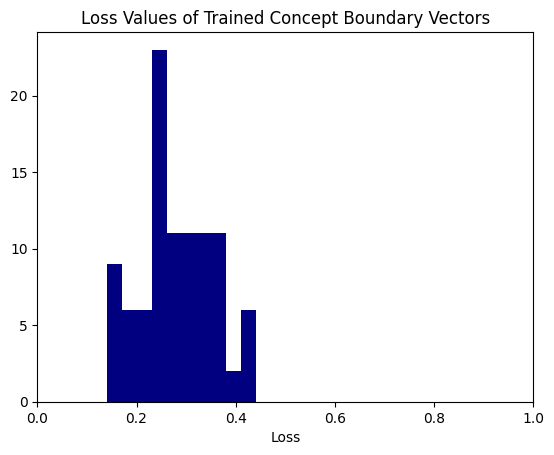

In [8]:
log_file=open(f'{external_path}\\concept_boundary_vectors\\log.txt','r')
losses=[]
for line in log_file.readlines():
    losses.append(float(line.split('=')[1][:-2]))
log_file.close()
colors=plt.cm.jet(np.linspace(0,1,2))
plt.hist(losses,color=colors[0])
plt.xlim(0,1)
plt.title('Loss Values of Trained Concept Boundary Vectors')
plt.xlabel('Loss')
plt.show()

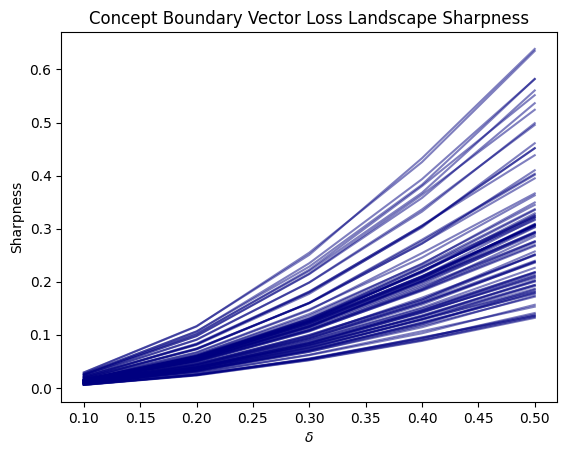

In [20]:
loss_sharpness_file=open(f'{external_path}\\concept_boundary_vectors\\loss_sharpness','rb')
loss_sharpness=pickle.load(loss_sharpness_file)
loss_sharpness_file.close()
colors=plt.cm.jet(np.linspace(0,1,2))
for values in loss_sharpness.values():
    plt.plot(np.arange(0.1,0.51,0.1),values,alpha=0.5,color=colors[0])
plt.title('Concept Boundary Vector Loss Landscape Sharpness')
plt.ylabel('Sharpness')
plt.xlabel('$\\delta$')
plt.show()